In [56]:
import pandas as pd
import cptac
import numpy as np
import requests
import json
import deva
import binarization_functions_1 as bf
import sksurv
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [13]:
cptac.download(dataset='ovarian', version='0.0')

True

In [14]:
ov = cptac.Ovarian()
clinical = ov.get_clinical()
proteomics = ov.get_proteomics()

In [15]:
follow_up = pd.read_excel('../Follow_Up_Data/Ovary_One_Year_Clinical_Data_20160927.xls')

In [16]:
follow_up.head()

,Short Title,PPID,Event,Modified Time,Modified By,Status,CRF Name,Date of Last Contact (Do not answer if patient is deceased),Vital Status (at time of last contact),Date of Death,...,Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted to CPTAC to Date Radiation Therapy Started for this Other Malignancy,Was the patient staged using FIGO?,FIGO Staging System (Gynecologic Tumors Only),FIGO Stage,Was the patient staged using AJCC?,AJCC Cancer Staging Edition,Pathologic Spread: Primary Tumor (pT),Pathologic Spread: Lymph Nodes (pN),Distant Metastases (M),AJCC Tumor Stage
0,CPTAC-WU-01OV,01OV002,Collection,2016-04-22,"Khandekar, Divya",Locked,One Year,2015-03-18,Living,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPTAC-WU-01OV,01OV002,Collection,2016-04-22,"Khandekar, Divya",Locked,Pharmaceutical Supplemental form,NaT,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPTAC-WU-01OV,01OV002,Collection,2016-04-22,"Khandekar, Divya",Locked,Pharmaceutical Supplemental form,NaT,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPTAC-WU-01OV,01OV002,Collection,2016-04-22,"Khandekar, Divya",Locked,Pharmaceutical Supplemental form,NaT,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPTAC-WU-01OV,01OV007,Collection,2016-04-22,"Khandekar, Divya",Locked,One Year,2015-03-10,Living,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
for col in follow_up.columns:
    if len(follow_up[col].value_counts()) <= 1:
        follow_up = follow_up.drop(col, axis=1)

cols_to_drop = ['Short Title', 'Event', 'Modified Time',
                'Modified By', 'Status', 'CRF Name', 
                'Was a Review of the Initial Pathological Findings Done?', 
                'Was the Pathology Review consistent with the Diagnosis?', 
                'Adjuvant (Post-Operative) Radiation Therapy', 
                'Adjuvant (Post-Operative) Immunotherapy', 
                'Adjuvant (Post-Operative) Hormone Therapy', 
                'Anatomic Site of New Tumor Event', 
                'Other Site of New Tumor Event or Lymph Node Location', 
                'Method Of Diagnosis of New Tumor Event', 
                'Date of Additional Surgery for New Tumor Event', 
                'Additional Hormone Therapy Treatment of New Tumor Event', 
                'Additional Targeted Molecular Therapy Treatment of New Tumor Event', 
                'What Type of Malignancy was This?', 'Primary Site of Disease', 
                'Laterality of the Disease', 'Did the patient have surgery for this malignancy?',
                'Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to the Date of Initial Diagnosis of Other Malignancy', 
                'Did the patient receive pharmaceutical therapy for this malignancy?', 
                'Was the patient staged using FIGO?', ' Was the patient staged using AJCC?']

follow_up = follow_up.drop(cols_to_drop, axis=1).copy()

things_to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown', 
                     'Not Applicable', 'na', 'unknown', 'Not Performed', 
                     'Unknown tumor status', 'Unknown']

for col in follow_up.columns:
    follow_up[col] = follow_up[col].replace(things_to_replace, np.nan)

chemo_to_replace = ['Chemotherapy', 'Chemo', 'chemotherapy']
phase_to_replace = ['Phase I', 'Phase 1', 'Pahse I', 'With other Phase I drug']
inhibitors_to_replace = ['PARP Inhibitor', 'aromatase inhibitor']
other_to_replace = ['alkylating agent', 'plant alkaloid', 
                    'monoclonal antibody', 'GOG9923']

col = 'Clinical Trial Drug Classification'

follow_up[col] = follow_up[col].replace(chemo_to_replace, 'Chemotherapy')
follow_up[col] = follow_up[col].replace(phase_to_replace, 'Phase I')
follow_up[col] = follow_up[col].replace(inhibitors_to_replace, 'Inhibitors')
follow_up[col] = follow_up[col].replace(other_to_replace, 'Other')

In [18]:
follow_up = follow_up.rename({'PPID': 'Patient_ID'}, axis='columns')

In [19]:
patient_data = pd.merge(clinical, follow_up, on = 'Patient_ID')

In [32]:
clinical.columns

Index(['Patient_ID', 'Sample_Tumor_Normal', 'Participant_Procurement_Age',
       'Participant_Gender', 'Participant_Race', 'Participant_Ethnicity',
       'Participant_Jewish_Heritage', 'Participant_History_Malignancy',
       'Participant_History_Chemotherapy',
       'Participant_History_Neo-adjuvant_Treatment',
       'Participant_History_Radiation_Therapy',
       'Participant_History_Hormonal_Therapy', 'Aliquots_Plasma',
       'Blood_Collection_Time', 'Blood_Collection_Method', 'Anesthesia_Time',
       'Tumor_Surgical_Devascularized_Time', 'Tumor_Sample_Number',
       'Tumor_Sample_1_Weight', 'Tumor_Sample_1_LN2_Time',
       'Tumor_Sample_1_Ischemia_Time', 'Tumor_Sample_2_Weight',
       'Tumor_Sample_2_LN2_Time', 'Tumor_Sample_2_Ischemia_Time',
       'Tumor_Sample_3_Weight', 'Tumor_Sample_3_LN2_Time',
       'Tumor_Sample_3_Ischemia_Time', 'Tumor_Sample_4_Weight',
       'Tumor_Sample_4_LN2_Time', 'Tumor_Sample_4_Ischemia_Time',
       'Tumor_Sample_5_Weight', 'Tumor_Sample

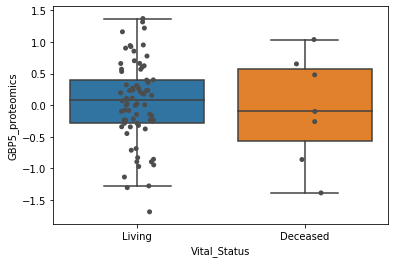

In [51]:
#Sam's Code
omics_genes=["GBP2", "GBP5", "RAC2"]
df = ov.join_metadata_to_omics(metadata_df_name="clinical", 
                                       omics_df_name="proteomics", 
                                       metadata_cols="Vital_Status",# 'Days_Between_Collection_And_Last_Contact'],
                                       omics_genes=["GBP2", "GBP5", "RAC2"])

df1 = ov.reduce_multiindex(df, levels_to_drop="Database_ID")

clinical_attribute = "Vital_Status"
data_col = "GBP5_proteomics"
sns.boxplot(x="Vital_Status", y=data_col, data=df1, showfliers=False)
sns.stripplot(x="Vital_Status", y=data_col, data=df1, color='0.3')
plt.show()

In [42]:
df_clean = df1.dropna(axis=0, how='any')
living = df_clean[df_clean["Vital_Status"] == 'Living']
dead = df_clean[df_clean["Vital_Status"] == 'Deceased']
#living
for gene in omics_genes:
    print(gene)
    gene += "_proteomics"
    print(scipy.stats.ttest_ind(living[gene], dead[gene]), '\n')

GBP2
Ttest_indResult(statistic=0.9376885702119404, pvalue=0.3512624078297031) 

GBP5
Ttest_indResult(statistic=0.4142003164633323, pvalue=0.6798498748343362) 

RAC2
Ttest_indResult(statistic=1.1437298743557582, pvalue=0.2561895567872052) 



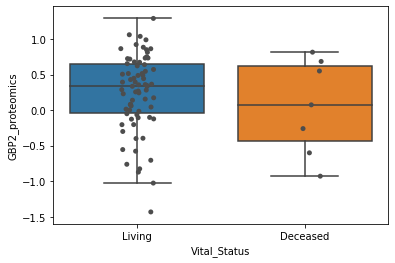

In [52]:
#Sam's Code
omics_genes=["GBP2", "GBP5", "RAC2"]
df = ov.join_metadata_to_omics(metadata_df_name="clinical", 
                                       omics_df_name="proteomics", 
                                       metadata_cols=["Vital_Status", 'Days_Between_Collection_And_Last_Contact'],
                                       omics_genes=["GBP2", "GBP5", "RAC2"])

df1 = ov.reduce_multiindex(df, levels_to_drop="Database_ID")

clinical_attribute = "Vital_Status"
data_col = "GBP2_proteomics"
sns.boxplot(x="Vital_Status", y=data_col, data=df1, showfliers=False)
sns.stripplot(x="Vital_Status", y=data_col, data=df1, color='0.3')
plt.show()

In [149]:
copy = df1.copy()
omics_cols = ['GBP2_proteomics', 'GBP5_proteomics', 'RAC2_proteomics']

for col in omics_cols:
    lower_25_filter = copy[col] <= copy[col].quantile(.25)
    upper_25_filter = copy[col] >= copy[col].quantile(.75)

    copy[col] = np.where(lower_25_filter, "Lower_25%", copy[col])
    copy[col] = np.where(upper_25_filter, "Upper_25%", copy[col])
    copy[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", copy[col])
    
copy['Vital_Status'] = copy['Vital_Status'].replace('Living', False)
copy['Vital_Status'] = copy['Vital_Status'].replace('Deceased', True)

#copy = copy.dropna()

In [157]:
#Because we don't have the time frame for the deceased people, 
#a Kaplan Meier plot is both impossible and useless
copy = df1.copy()
copy[copy['Vital_Status'] == "Deceased"]

Name,Vital_Status,Days_Between_Collection_And_Last_Contact,GBP2_proteomics,GBP5_proteomics,RAC2_proteomics
Sample_ID,,,,,
S011,Deceased,NaN,0.684596,1.039641,0.347294
S061,Deceased,NaN,0.550095,0.481031,0.567427
S066,Deceased,NaN,-0.599716,-0.860110,-0.378419
S067,Deceased,NaN,0.074519,-0.259718,0.221343
S069,Deceased,NaN,0.814846,0.654045,0.589899
S083,Deceased,NaN,NaN,NaN,NaN
S095,Deceased,NaN,-0.259120,-0.098505,-0.071598
S107,Deceased,NaN,-0.927487,-1.389054,-0.106615


In [153]:
copy_subset['Vital_Status'].dropna().value_counts()

False    95
Name: Vital_Status, dtype: int64

In [150]:
copy_subset = copy[['GBP2_proteomics', 'Vital_Status', 
                    'Days_Between_Collection_And_Last_Contact']]
copy_subset = copy_subset.dropna()

In [151]:
for value in copy_subset['GBP2_proteomics'].unique():
    mask = copy_subset['GBP2_proteomics'] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(copy_subset["Vital_Status"][mask],
                                                           copy_subset["Days_Between_Collection_And_Last_Contact"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.35, 1), shadow=True, ncol=1)
#plt.title('Survival Risk for TP53 Mutations')
plt.show()

ValueError: elements of event indicator must be boolean, but found float64